# Quantum State Teleportation
By using entanglement, we can teleport any quantum state of a qubit to another across an arbitrary distance in space. The original qubit will lose its state but the entangled destination qubit will recieve its exact state in superpostion. Alice will be attempting to teleport the state of one of her qubits to one of Bob's qubits.

## Imports

In [ ]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.quantum_info import random_statevector
from qiskit.result import marginal_counts
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
#IBMQ.save_account(TOKEN)
provider = IBMQ.load_account()

## Teleportation Circuit

In [96]:
def create_bell_pair(qc, a, b):
    qc.h(a)
    qc.cx(a,b)

In [97]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [98]:
def measure_and_send(qc, a, b):
    qc.measure(a,0)
    qc.measure(b,1)

In [99]:
def bob_gates(qc, qubit, crz, crx):
    # apply rotation around Y-axis if the registers are in state '1'
    qc.x(qubit).c_if(crx, 1)
    qc.z(qubit).c_if(crz, 1)

## Simulating the Teleportation of Quantum States

In [100]:
# 1 Quantum register with 3 qubits
qr = QuantumRegister(3, name="q")

# 2 Different classical registers both containing 2 bits
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
tpqc = QuantumCircuit(qr, crz, crx)

<IPython.core.display.Latex object>

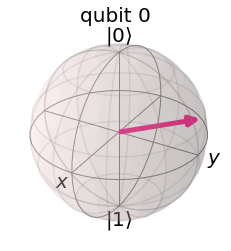

In [101]:
# Random qubit state to send
psi = random_statevector(2)
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
plot_bloch_multivector(psi)

In [102]:
# The gate that transforms Alice's bit into psi
init_gate = Initialize(psi)
init_gate.label = "Psi"

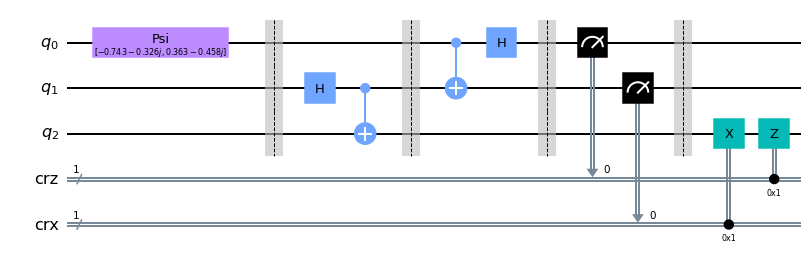

In [103]:
tpqc.append(init_gate, [0])
tpqc.barrier()

create_bell_pair(tpqc, 1, 2)
tpqc.barrier()

alice_gates(tpqc, 0, 1)

tpqc.barrier()
measure_and_send(tpqc, 0 ,1)
tpqc.barrier()

bob_gates(tpqc, 2, crz, crx)

tpqc.draw(output='mpl')

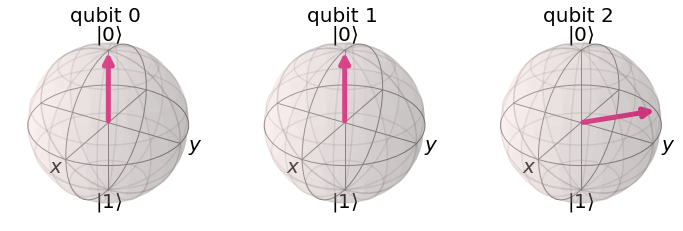

In [104]:
sim = Aer.get_backend('aer_simulator')
tpqc.save_statevector()
out_vector = sim.run(tpqc).result().get_statevector()
plot_bloch_multivector(out_vector)

## Using a Disentangler
Because it is impossible to measure a quantum state without it collapsing into the computational basis, we will use a disentangler to perfectly reverse the original quantum state. This will all allow us to properly measure the resultant qubit. If the measurement is 1, then we know that teleportation didn't work because the bit was 0 before the psi transformation.

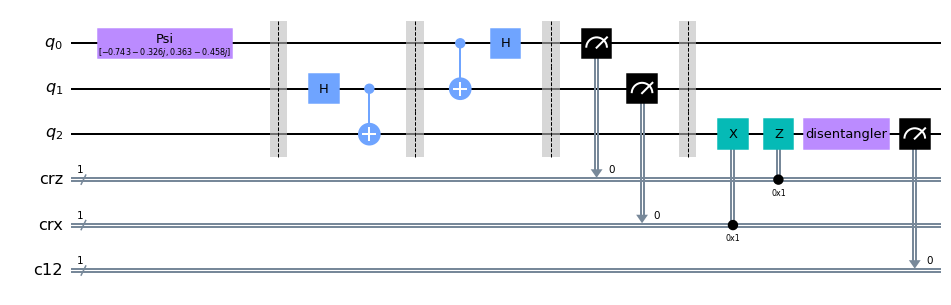

In [105]:
# 1 Quantum register with 3 qubits
qr = QuantumRegister(3, name="q")

# 2 Different classical registers both containing 2 bits
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
tpqc = QuantumCircuit(qr, crz, crx)

tpqc.append(init_gate, [0])
tpqc.barrier()

create_bell_pair(tpqc, 1, 2)
tpqc.barrier()

alice_gates(tpqc, 0, 1)

tpqc.barrier()
measure_and_send(tpqc, 0 ,1)
tpqc.barrier()

bob_gates(tpqc, 2, crz, crx)

inverse_init_gate = init_gate.gates_to_uncompute() #Reverse Psi gate
tpqc.append(inverse_init_gate, [2])

cr = ClassicalRegister(1) # Observe result
tpqc.add_register(cr)
tpqc.measure(2,2)

tpqc.draw(output='mpl')

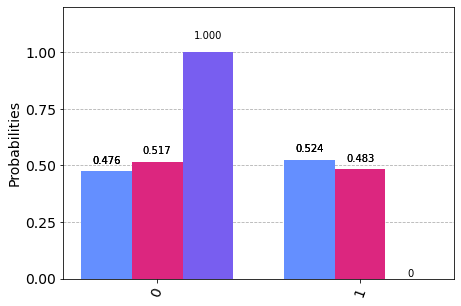

In [106]:
tqc = transpile(tpqc, sim)
tqc.save_statevector()
counts = sim.run(qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)

## Executing in Reality
To make the circuit compatible with IBM's quantum hardware, Bob's gates will have to be adjusted slightly. We will use control gates to determine how to rotate the qubit around the Bloch sphere. In effect, this will be the same as before.

In [111]:
def bob_gates2(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

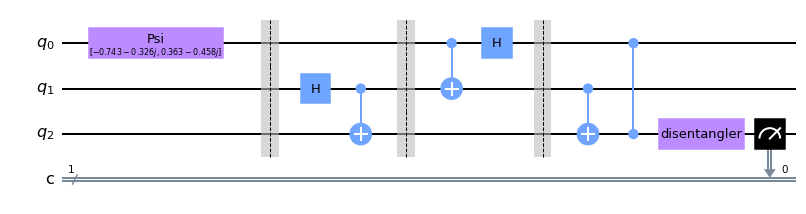

In [112]:
qc = QuantumCircuit(3, 1)

qc.append(init_gate, [0])
qc.barrier()

create_bell_pair(qc, 1, 2)
qc.barrier()

alice_gates(qc, 0, 1)
qc.barrier()

bob_gates2(qc, 0, 1, 2)

inverse_init_gate = init_gate.gates_to_uncompute() #Reverse Psi gate
qc.append(inverse_init_gate, [2])

qc.measure(2,0) # measure teleported bit

qc.draw(output='mpl')

In [115]:
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))

tqc = transpile(qc, backend, optimization_level=3)
print("Least busy: ", backend)

%qiskit_job_watcher

job = backend.run(tqc)

Least busy:  ibmq_lima


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

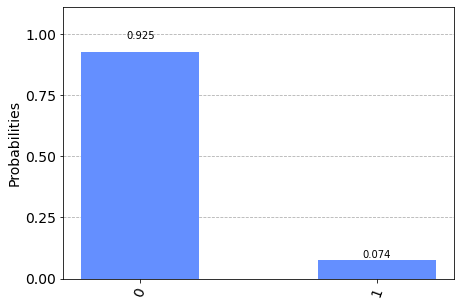

In [117]:
counts = job.result().get_counts(qc)
plot_histogram(counts)